In [17]:
import sys
sys.path.append('../mist-base/GW')
sys.path.append('../mist-base/')
sys.path.append('../mist-base/utils')

import gw150814_simulator as gs
# import module

import torch
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
pf.housestyle_rcparams()

import matplotlib.pyplot as plt

import os, sys

from simulators.additive import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

# Simulations and Utils
## Creating some distorted data
Let us start by defining some data using an additive simulator. Note that we want 100,000 samples of data here, 100 bins (indicated by the blue points), and we set ourselves a likelihood covariance of 1 - this noise is sampled along the standard normal distribution.

In order to understand what is going on, we first should understand what `Simulator_Additive` actually produces.

NOTE: This block produces random data at each point.

True

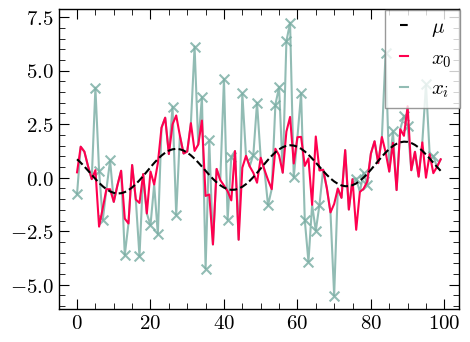

In [39]:
Nsims = 100_000
Nbins = 100
SIGMA = 1
simulator = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bounds=5, fraction=0.5, bkg=True, dtype=torch.float64)     
samples = simulator.sample(Nsims=Nsims)  

fig, ax1 = pf.create_plot(size=(4,3))
ax1.plot(samples['mu'][0], label=r'$\mu$', c='k', ls='--', zorder=10)
ax1.plot(samples['x0'][0], label='$x_0$',color='#ff004f', zorder=9)
ax1.plot(samples['xi'][0], label='$x_i$', color='#77aca2', alpha=.8)
idx = torch.where(samples['ni'][0] != 0)
ax1.scatter(idx, samples['xi'][0][idx], marker='x', s=50, color='#77aca2', alpha=.8)
fig.legend()
pf.fix_plot([ax1])


## Analytical Utils
Next we want a maxmimum likelihood estimation (MLE) of the data, so that we can compare with the network's profiled likelihood. For this we use the function best_fit() from simulator.utils, which simply does a scipy data fit on some model data. Note that each time we take a copy of the dotted line mu, apply some random pertubation from the standard normal, and then best fit these - this then gets plotted each time: we expect the spread across the line to look something like a normal distribution (which it visually does!). Again this is created stochastically so the plot looks different each time.

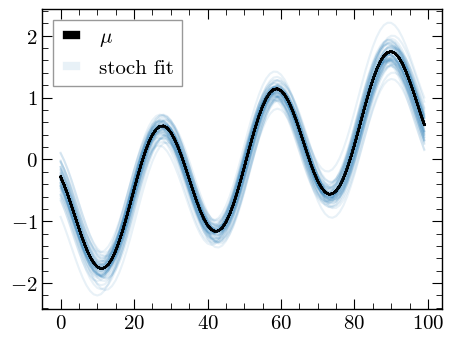

In [54]:
fig, ax1 = pf.create_plot(size=(4,3))
sample = simulator.sample(1)
for _ in range(50):
    x = sample['mu'].clone()
    x += (torch.randn_like(x) * SIGMA)
    fit = best_fit(x[0], simulator)[0]
    ax1.plot(sample['mu'][0], c='k', label=((r'$\mu$')if _==0 else None))
    ax1.plot(fit, alpha=0.1, c='C0', label=((r'stoch fit')if _==0 else None))
pf.fix_plot([ax1])
ax1.legend()